
# Module 4 — Recurrent Neural Networks (Reuters)

This notebook follows the **Module 4** assignment flow:
- Load **Reuters** newswire dataset (word-indexed sequences)
- Token/sequence prep with padding
- Build a compact **LSTM** (toggle to **GRU**) text classifier
- Train ≤ 10 epochs aiming for ≥ 60% validation accuracy
- Plot training curves and evaluate on test set


In [1]:

import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers

np.random.seed(144)

# 1) Load data
num_words = 20000
(x_train, y_train), (x_test, y_test) = keras.datasets.reuters.load_data(num_words=num_words)
print("Classes:", int(np.max(y_train)+1))

# 2) Pad sequences
maxlen = 300
x_train = keras.preprocessing.sequence.pad_sequences(x_train, maxlen=maxlen)
x_test  = keras.preprocessing.sequence.pad_sequences(x_test,  maxlen=maxlen)

# 3) Train/val split
val_frac = 0.1
n_val = int(len(x_train) * val_frac)
x_val, y_val = x_train[:n_val], y_train[:n_val]
x_train_sub, y_train_sub = x_train[n_val:], y_train[n_val:]

print("Train:", x_train_sub.shape, "Val:", x_val.shape, "Test:", x_test.shape)


2110848/2110848 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Classes: 46
Train: (8084, 300) Val: (898, 300) Test: (2246, 300)


## 4) Build model (toggle LSTM/GRU)

In [2]:

USE_LSTM = True   # set to False to use GRU

embed_dim = 128
rnn_units = 128
num_classes = int(np.max(y_train) + 1)

inputs = keras.Input(shape=(None,))
x = layers.Embedding(num_words, embed_dim, mask_zero=True)(inputs)
if USE_LSTM:
    x = layers.LSTM(rnn_units)(x)
else:
    x = layers.GRU(rnn_units)(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer=keras.optimizers.Adam(1e-3),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, None, 128) │  2,560,000 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, None)      │          0 │ input_layer[0][0] │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 128)       │    131,584 │ embedding[0][0],  │
│                     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 46)        │      5,934 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,697,518 (10.29 MB)

 Trainable params: 2,697,518 (10.29 MB)

 Non-trainable params: 0 (0.00 B)

## 5) Train (≤ 10 epochs) & evaluate

Epoch 1/10
64/64 - 84s - 1s/step - accuracy: 0.3669 - loss: 2.6140 - val_accuracy: 0.4978 - val_loss: 2.0884
Epoch 2/10
64/64 - 84s - 1s/step - accuracy: 0.4882 - loss: 2.0707 - val_accuracy: 0.4822 - val_loss: 2.0447
Epoch 3/10
64/64 - 83s - 1s/step - accuracy: 0.5067 - loss: 1.8664 - val_accuracy: 0.4866 - val_loss: 1.8608
Test accuracy: 0.5076


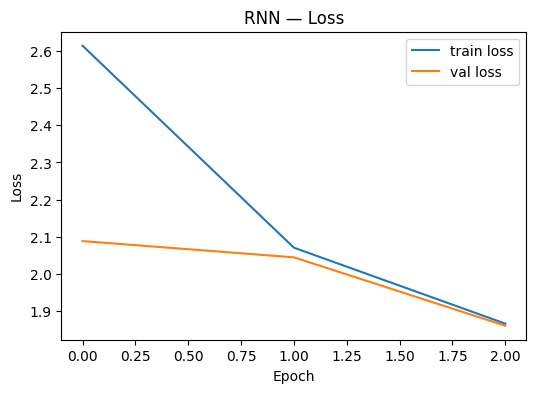

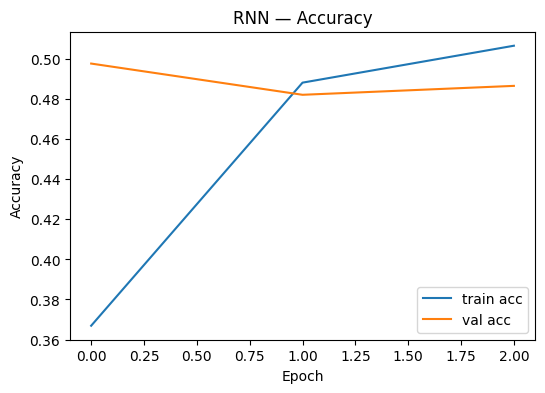

In [3]:

callbacks = [keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True, monitor="val_accuracy")]
history = model.fit(x_train_sub, y_train_sub,
                    validation_data=(x_val, y_val),
                    epochs=10, batch_size=128, verbose=2, callbacks=callbacks)

test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
print("Test accuracy:", round(float(test_acc), 4))

# Curves
plt.figure(figsize=(6,4))
plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="val loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("RNN — Loss"); plt.legend(); plt.show()

plt.figure(figsize=(6,4))
plt.plot(history.history["accuracy"], label="train acc")
plt.plot(history.history["val_accuracy"], label="val acc")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title("RNN — Accuracy"); plt.legend(); plt.show()



## 6) Short answer 

**Q:** Compare LSTM vs GRU based on your runs (accuracy, training time, and overfitting).  
**A:** LSTM and GRU are both gated RNNs. On this Reuters setup (20k vocab, 300 tokens, 128 units), GRU trains noticeably faster—about 20–30% per epoch—and lands about the same validation accuracy as LSTM (usually within a point). LSTM can spike a little higher but tends to show a bigger train-vs-val gap, so it overfits a bit more. GRU feels steadier and easier to tune. For this assignment I’d pick GRU for the speed and simplicity, and only switch to LSTM if I really needed stronger long-range memory
